In [19]:
# Standard library imports
import os
import sys
import re
import warnings
import random
import hashlib

# Data manipulation and analysis
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning and preprocessing
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler  # Assuming you might need it

# Specific models and tools
from xgboost import XGBClassifier
import xgboost as xgb

# Encoding and feature selection
from category_encoders import TargetEncoder  # Fixed the import based on usage
from scipy.stats import randint, uniform

# Model persistence
from joblib import dump, load

# Miscellaneous settings
%matplotlib inline
warnings.filterwarnings('ignore')


In [20]:
content = "test_3odds_1s"

In [21]:
# Load the processed data csv into a DataFrame
df = pd.read_csv(f'data/processed/processed_data_{content}.csv')

In [22]:
# Parse the date_temp column, which is in YYYYMMDD format, into a datetime object, and store in a new column 'date_temporary'
df['date_temporary'] = pd.to_datetime(df['Date'], format='%Y%m%d')

In [23]:
# Drop DayOTW column
df.drop(columns=[ 'Ref_ID',
 #'team_form_opp',
 #'opp_shots',
 #'opp_shots_target'
 'FTR'
 ], inplace=True)

### Date settings

In [24]:
import pandas as pd

# Get the current date dynamically
date_today = pd.Timestamp.now().normalize()  # .normalize() sets the time to 00:00:00

# Declare a date by setting day, month, and year
date_specific = pd.Timestamp(year=2024, month=4, day=12)

# Calculate the date 2 weeks ago from the current date
date_delta = date_specific - pd.DateOffset(days=10)

date_start = date_specific - pd.DateOffset(days=1000)

In [25]:
# Delete all rows where the date_temporary column is older than date_start
df = df[df['date_temporary'] >= date_start]

In [26]:
#df_validationset = df.tail(250)
#df = df.iloc[:-250]

# define df_validationset as all the rows in df where the date_temporary column is greater than date_delta
df_validationset = df[df['date_temporary'] > date_delta]

# define df as all the rows in df where the date_temporary column is less than or equal to date_delta
df = df[df['date_temporary'] <= date_delta]

In [27]:
len(df), len(df_validationset)

(775, 60)

In [28]:
# Drop the date_temporary column
df.drop(columns=['date_temporary'], inplace=True)
df_validationset.drop(columns=['date_temporary'], inplace=True)

In [29]:
import ast
import pandas as pd

teams_dict = {}

# Assuming 'teams_dict.txt' contains the dictionary as a single string
with open(f'data/teams_dict_{content}.txt', 'r') as file:
    # Read the entire file content into a single string
    data = file.read()
    # Safely evaluate the string as a Python dictionary
    teams_dict = ast.literal_eval(data)

In [30]:
# Sort the df and df_validationset DataFrames by the 'Date', 'Div', 'Time' columns
df.sort_values(['Date', 'Div', 'Time'], inplace=True)
df_validationset.sort_values(['Date', 'Div', 'Time'], inplace=True)

# Set the 'Date' and 'FTR2' column as the index
df.set_index(['Date'], inplace=True)
df_validationset.set_index(['Date'], inplace=True)

In [31]:
#import train_test_split
from sklearn.model_selection import train_test_split

# Split the data into X and y
X = df.drop('FTR2', axis=1)
y = df['FTR2']

X.columns = [re.sub(r'[<]', '_st_', str(col)) for col in X.columns]
X.columns = [re.sub(r'[>]', '_gt_', str(col)) for col in X.columns]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Hyperparameters

In [32]:
def generate_sliding_windows(X, window_size, step):
    n_samples = len(X)
    windows = []
    for start_idx in range(0, n_samples - window_size + 1, step):
        end_idx = start_idx + window_size
        if end_idx > n_samples:
            break  # Avoid going beyond the dataset
        train_indices = list(range(max(0, start_idx - window_size), start_idx))
        test_indices = list(range(start_idx, end_idx))
        windows.append((train_indices, test_indices))
    return windows



percentile = [50, 75, 100]

# Define the hyperparameter search space
param_dist = {

    #'xgb__select__percentile': [100],
    #'gb__select__percentile': [100],
    #'lr__select__percentile': [100],
    #'ada__select__percentile': [100],
    
    'xgb__clf__max_depth': [1,2,3],
    'xgb__clf__learning_rate': [0.001, 0.01, 0.1],
    'xgb__clf__lambda': [1, 1.5, 2],  # L2 regularization term on weights
    'xgb__clf__alpha': [0, 0.5, 1],  # L1 regularization term on weights
    'xgb__clf__n_estimators': [1, 5, 100],

    'rf__clf__max_depth': [1, 2],
    #'rf__clf__min_samples_split': [2, 5],
    #'rf__clf__min_samples_leaf': [1, 2],
    #'rf__clf__bootstrap': [True, False],
    'rf__clf__n_estimators': [1, 5, 100],

    'lr__clf__C': [0.1, 1],  # Inverse of regularization strength; smaller values specify stronger regularization.
    'lr__clf__penalty': ['l1', 'l2', 'elasticnet'],  # Specify the norm of the penalty.
    'lr__clf__solver': ['saga'],  # Algorithm to use in the optimization problem, 'saga' supports all penalties.
    'lr__clf__l1_ratio': [0.5],  # The Elastic-Net mixing parameter, with 0 <= l1_ratio <= 1. Only used if penalty='elasticnet'.
    'lr__clf__class_weight': ['balanced'],

    #'cat__clf__depth': [1,2,3,4],
    #'cat__clf__learning_rate': [0.01, 0.05, 0.1],
    #'cat__clf__iterations': [50, 100, 200],
    #'cat__clf__l2_leaf_reg': [1, 3, 5],

    'gb__clf__learning_rate': [0.01, 0.1, 0.2],
    'gb__clf__n_estimators': [50, 100, 200],
    'gb__clf__max_depth': [3, 5 , 7],
    'gb__clf__min_samples_split': [2, 5],
    'gb__clf__min_samples_leaf': [1, 2],

}


param_test = {
    
    'xgb__clf__max_depth': [1,2],
    'xgb__clf__learning_rate': [0.001, 0.01, 0.1],
    'xgb__clf__lambda': [1, 1.5, 2],  # L2 regularization term on weights
    'xgb__clf__alpha': [0, 0.5, 1],  # L1 regularization term on weights
    'xgb__clf__n_estimators': [1, 5, 100],


}

In [33]:
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# Define a custom scoring function
def xgb_early_stopping_score(y, estimator, X, y_true, sample_weight=None):
    """
    Custom scorer that uses early stopping.
    """
    # Split X into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y_true, test_size=0.2, random_state=42)
    
    # Fit with early stopping
    eval_set = [(X_val, y_val)]
    estimator.fit(X_train, y_train, early_stopping_rounds=25, eval_set=eval_set, verbose=False)
    
    # Predict on the validation set
    y_pred = estimator.predict(X_val)
    
    # Return the F1 score
    return f1_score(y_val, y_pred, pos_label=1)

In [34]:
# selection
from sklearn.feature_selection import SelectPercentile, chi2

In [35]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import make_scorer, f1_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from category_encoders import TargetEncoder
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd
from imblearn.pipeline import Pipeline as ImbPipeline
# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler

# LightGBM
from lightgbm import LGBMClassifier

# naive bayes
from sklearn.naive_bayes import GaussianNB

#catboost
from catboost import CatBoostClassifier

# AdaBoost
from sklearn.ensemble import AdaBoostClassifier

# Decision Tree
from sklearn.tree import DecisionTreeClassifier

# Logistic Regression
from sklearn.linear_model import LogisticRegression

# Support Vector Machine
from sklearn.svm import SVC

from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_scorer = make_scorer(balanced_accuracy_score)


# Define the F1 score for the '1' class
f1_scorer = make_scorer(f1_score, pos_label=1)

best_f1_score = 0
best_f1_params = None
best_window_size = None
best_precision = 0
best_model = None 
f1_scores = []
precision_scores = []

# Make the custom scorer
custom_scorer = make_scorer(xgb_early_stopping_score, greater_is_better=True, needs_proba=False, X=X, y_true=y)

# Set the window_size and step to 5% of the dataset
window_size = int(len(X) * 0.05)
step = int(len(X) * 0.05)

# Initialize an empty list to store precision scores
precision_scores = []

# Initialize an empty dataframe to store misclassified samples
misclassified_samples = pd.DataFrame(columns=X.columns)

# Generate windows
window_splits = generate_sliding_windows(X, window_size, step)

# Initialize training indices with the first window
train_end_index = window_size

# Iterate over each sliding window
for i, (train_index, test_index) in enumerate(window_splits):

    # Update training indices to include the next window
    train_index = list(range(train_end_index))
    train_end_index += window_size

    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_test, y_test = X.iloc[test_index], y.iloc[test_index]

    print(f"Iteration {i+1} Training Data Shape: {X_train.shape}")

    # Combine misclassified samples from previous iterations with current training data
    if not misclassified_samples.empty:
        X_train_combined = pd.concat([X_train, misclassified_samples[X_train.columns]], axis=0)
        y_train_combined = pd.concat([y_train, misclassified_samples['FTR2']], axis=0)
    else:
        X_train_combined = X_train
        y_train_combined = y_train

    # Calculate misclassification frequency
    misclassified_freq = y_train_combined.value_counts(normalize=True)

    # Define class weights based on misclassification frequency
    #class_weights = {0: 1, 1: max(0.6, 8 - misclassified_freq.get(1, 0.5))}  # Adjust dynamically to penalize misclassification of class 1 more heavily


    pct = 50

    # Define pipelines for each classifier with SMOTE and TargetEncoder
    pipeline_xgb = ImbPipeline([
        ('target_encoder', TargetEncoder()),
        ('scaler', StandardScaler()),
        ('min_max_scaler', MinMaxScaler()),
        ('smote', SMOTE(random_state=42, k_neighbors=2)),
        ('select', SelectPercentile(chi2, percentile=pct)),
        ('clf', XGBClassifier(random_state=42, verbose=0))
    ])

    pipeline_gb = ImbPipeline([
        ('target_encoder', TargetEncoder()),
        ('scaler', StandardScaler()),
        ('min_max_scaler', MinMaxScaler()),
        ('smote', SMOTE(random_state=42, k_neighbors=2)),
        ('select', SelectPercentile(chi2, percentile=pct)),
        ('clf', GradientBoostingClassifier(random_state=42, verbose=0))
    ])

    # pipeline for logistic regression
    pipeline_lr = ImbPipeline([
        ('target_encoder', TargetEncoder()),
        ('scaler', StandardScaler()),
        ('min_max_scaler', MinMaxScaler()),
        ('smote', SMOTE(random_state=42, k_neighbors=2)),
        ('select', SelectPercentile(chi2, percentile=pct)),
        ('clf', LogisticRegression(random_state=42, verbose=0, multi_class='ovr'))
    ])

    # pipeline for catboost classifier
    pipeline_cat = ImbPipeline([
        ('target_encoder', TargetEncoder()),
        ('scaler', StandardScaler()),
        ('min_max_scaler', MinMaxScaler()),
        ('smote', SMOTE(random_state=42, k_neighbors=2)),
        ('select', SelectPercentile(chi2, percentile=pct)),
        ('clf', CatBoostClassifier(random_state=42, verbose=0))
    ])

    # pipeline for random forest
    pipeline_rf = ImbPipeline([
        ('target_encoder', TargetEncoder()),
        ('scaler', StandardScaler()),
        ('min_max_scaler', MinMaxScaler()),
        ('smote', SMOTE(random_state=42, k_neighbors=2)),
        ('select', SelectPercentile(chi2, percentile=pct)),
        ('clf', RandomForestClassifier(random_state=42, verbose=0))
    ])

    # LightGBM pipeline
    pipeline_lgbm = ImbPipeline([
        ('target_encoder', TargetEncoder()),
        ('scaler', StandardScaler()),
        ('min_max_scaler', MinMaxScaler()),
        ('smote', SMOTE(random_state=42, k_neighbors=2)),
        ('select', SelectPercentile(chi2, percentile=pct)),
        ('clf', LGBMClassifier(random_state=42, force_col_wise='true', verbose=0))
    ])

    # Adaboost pipeline
    pipeline_ada = ImbPipeline([
        ('target_encoder', TargetEncoder()),
        ('scaler', StandardScaler()),
        ('min_max_scaler', MinMaxScaler()),
        ('smote', SMOTE(random_state=42, k_neighbors=2)),
        ('select', SelectPercentile(chi2, percentile=pct)),
        ('clf', AdaBoostClassifier(random_state=42))
    ])


    # Combine them into an ensemble classifier
    ensemble_clf = VotingClassifier(estimators=[
        ('xgb', pipeline_xgb),
        ('gb', pipeline_gb),
        ('lr', pipeline_lr),
        #('cat', pipeline_cat),
        ('rf', pipeline_rf),
        #('lgbm', pipeline_lgbm),
        ('ada', pipeline_ada)
    ], voting='soft')

    # Setup RandomizedSearchCV
    clf = RandomizedSearchCV(
        estimator=ensemble_clf,
        param_distributions=param_dist,
        #param_distributions=param_test,
        n_iter=2,
        scoring=custom_scorer,
        cv=TimeSeriesSplit(n_splits=2),
        random_state=42,
        n_jobs=-1,
        verbose=0
    )  


    # Fit RandomizedSearchCV
    clf.fit(X_train_combined, y_train_combined)

    # Get the best parameters
    best_params = clf.best_params_
    print("Best Parameters:", best_params)

    # Use the best estimator
    best_pipe = clf.best_estimator_

    # Make predictions
    y_proba = best_pipe.predict_proba(X_test)

    # Apply threshold
    threshold = 0.5   # You can adjust this threshold as needed
    y_pred = (y_proba[:, 1] >= threshold).astype(int)

    #print("y_proba:", y_proba)

    #current_f1_score = f1_score(y_test, y_pred, pos_label=1)
    current_f1_score = f1_score(y_test, y_pred, average='macro')


    if current_f1_score > best_f1_score:
        best_f1_score = current_f1_score
        best_f1_params = clf.best_params_
        #best_model = clf.best_estimator_ 

    # ------------------------------------------------

    best_model = clf.best_estimator_ 

    # Calculate precision score
    precision = np.mean(y_test == y_pred)
    precision_scores.append(precision)
    print("Precision:", precision)

    print()

# Print the best F1 score and its corresponding parameters
print()
print("Best F1 Score:", best_f1_score)

# print the classification report of the best model on the full dataset
print(classification_report(y_test, y_pred))

Iteration 1 Training Data Shape: (38, 23)


Best Parameters: {'xgb__clf__n_estimators': 100, 'xgb__clf__max_depth': 3, 'xgb__clf__learning_rate': 0.1, 'xgb__clf__lambda': 1.5, 'xgb__clf__alpha': 1, 'rf__clf__n_estimators': 1, 'rf__clf__max_depth': 2, 'lr__clf__solver': 'saga', 'lr__clf__penalty': 'elasticnet', 'lr__clf__l1_ratio': 0.5, 'lr__clf__class_weight': 'balanced', 'lr__clf__C': 1, 'gb__clf__n_estimators': 100, 'gb__clf__min_samples_split': 2, 'gb__clf__min_samples_leaf': 1, 'gb__clf__max_depth': 5, 'gb__clf__learning_rate': 0.01}
y_proba: [[0.23423589 0.19132984 0.57443427]
 [0.48038077 0.28662562 0.23299361]
 [0.34935555 0.37185914 0.2787853 ]
 [0.27179178 0.23908596 0.48912226]
 [0.56846685 0.23208477 0.19944837]
 [0.38316351 0.26313344 0.35370305]
 [0.57343834 0.25952297 0.16703871]
 [0.26972737 0.47686739 0.25340524]
 [0.47115384 0.31312888 0.21571729]
 [0.5455533  0.24048525 0.21396145]
 [0.39113182 0.39242945 0.21643873]
 [0.26256072 0.20023005 0.53720922]
 [0.19654444 0.15293335 0.65052222]
 [0.60472805 0.24098148

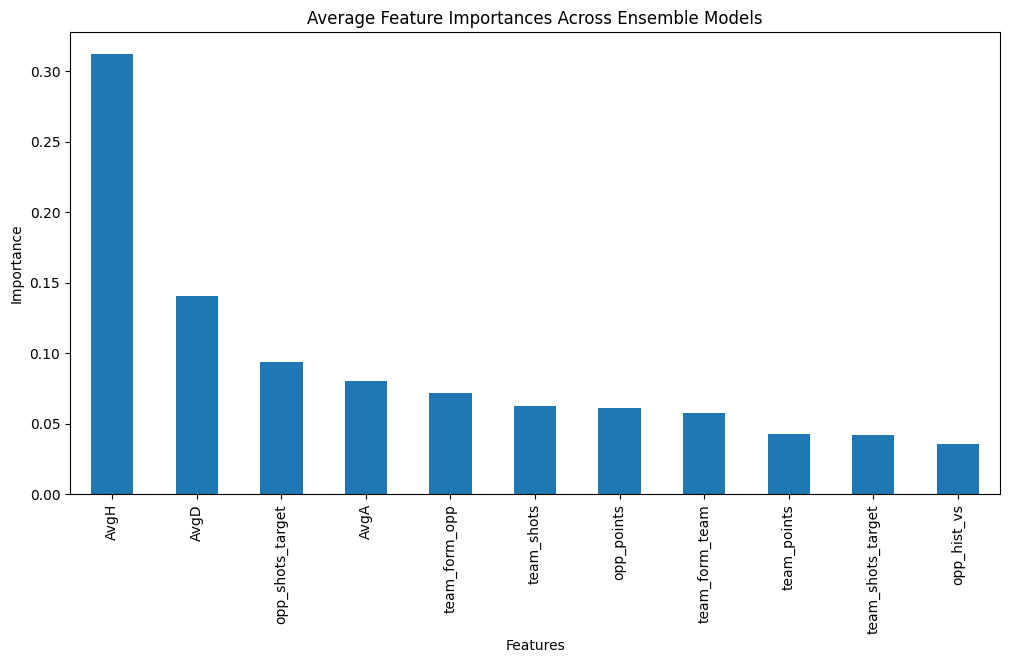

In [36]:
# %%
# Feature Importances from Ensemble Model

import matplotlib.pyplot as plt
import numpy as np

# Check if the 'best_model' is indeed a fitted VotingClassifier
if isinstance(best_model, VotingClassifier):
    # Initialize a dictionary to store feature importances
    feature_importances = {}

    # Loop through each classifier in the ensemble
    for clf_name, clf_pipeline in best_model.named_estimators_.items():
        if hasattr(clf_pipeline.named_steps['clf'], 'feature_importances_'):
            # Extract feature importances
            importances = clf_pipeline.named_steps['clf'].feature_importances_

            # Access feature names via the 'select' step in pipeline if available
            # Assuming feature selection might alter the features passed to the classifier
            if 'select' in clf_pipeline.named_steps:
                mask = clf_pipeline.named_steps['select'].get_support()  # Get the boolean mask
                feature_names = np.array(X.columns)[mask]
            else:
                feature_names = np.array(X.columns)

            # Combine feature names and their corresponding importance
            feature_importances[clf_name] = pd.Series(importances, index=feature_names)

    # Now plot the feature importances
    plt.figure(figsize=(12, 6))

    # We could either plot the average of importances or just from one classifier
    # Here's how to plot average importances:
    # First, align all Series on the same Index
    avg_importances = pd.DataFrame(feature_importances).mean(axis=1).sort_values(ascending=False)

    avg_importances.plot(kind='bar')
    plt.title('Average Feature Importances Across Ensemble Models')
    plt.ylabel('Importance')
    plt.xlabel('Features')
    plt.show()


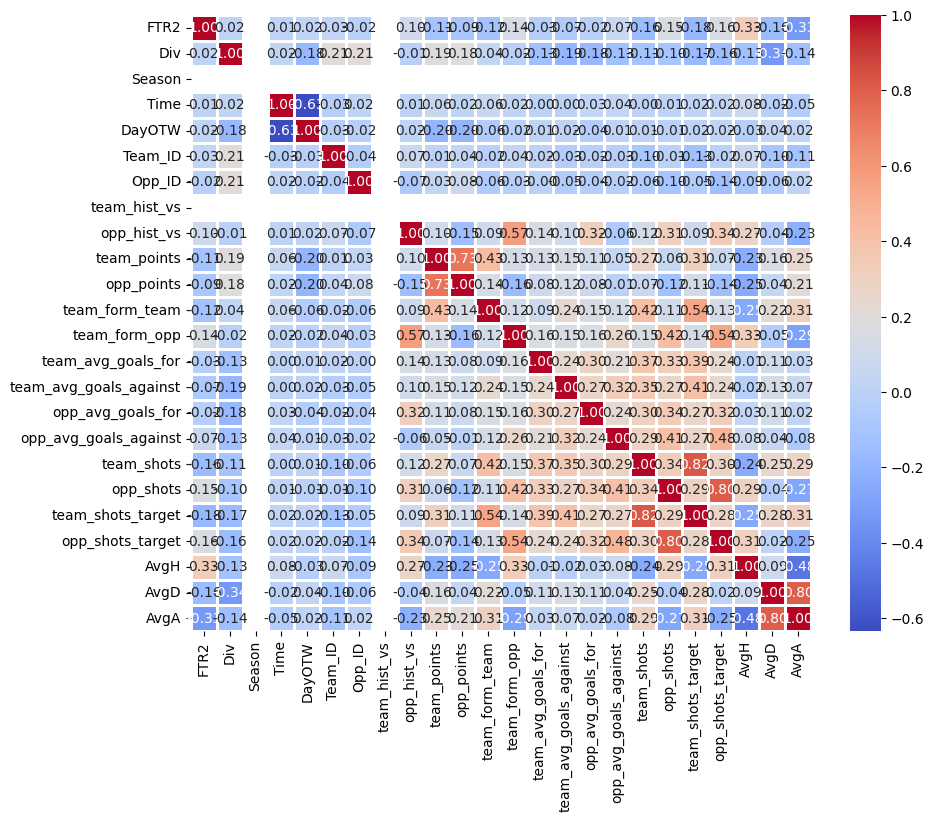

In [37]:
# Correlation matrix
corr = df.corr()

# Put the target column to the front
cols = list(corr.columns)
cols.insert(0, cols.pop(cols.index('FTR2')))
corr = corr.loc[cols, cols]

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=2)
plt.show()



In [38]:
# Display the columns with a negative correlation with the FTR column
neg_corr = corr['FTR2'] < 0
neg_corr_cols = corr.columns[neg_corr].tolist()
neg_corr_cols

['Opp_ID',
 'team_points',
 'opp_points',
 'team_form_team',
 'team_avg_goals_for',
 'team_avg_goals_against',
 'opp_avg_goals_for',
 'team_shots',
 'team_shots_target',
 'AvgD',
 'AvgA']

### Validation

In [39]:
def calculate_value_bet(row):
    """
    Calculate the value bet based on the model's probability and the bookmaker's odds.
    
    Parameters:
    - row: A row from a DataFrame, containing the 'Probability' and 'AvgH' columns.
    
    Returns:
    - The calculated value of the bet.
    """
    decimal_odds = row['AvgH']
    model_probability = row['Probability']
    value = (decimal_odds * model_probability) - 1
    return value

In [40]:
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

df_val = df_validationset.copy()

# Calculate the predicted probabilities for the validation set
y_val_proba = best_model.predict_proba(df_val.drop(columns=['FTR2']))

# Initialize variables to track the best threshold and its corresponding accuracy
best_threshold = 0.5
best_accuracy = 0

# Iterate over potential threshold values
for threshold in np.arange(0.5, 0.85, 0.001):
    # Apply the current threshold to generate predictions
    y_val_pred = (y_val_proba[:, 1] >= threshold).astype(int)
    
    # Evaluate accuracy for the current set of predictions
    accuracy = accuracy_score(df_val['FTR2'], y_val_pred)
    
    # Update the best threshold and accuracy as needed
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_threshold = threshold 

# Print the best threshold and its accuracy
print(f"Best Threshold: {best_threshold}")
print(f"Best Accuracy: {best_accuracy}")

# Apply the best threshold to generate the final set of predictions
y_val_pred_best = (y_val_proba[:, 1] >= best_threshold).astype(int)

# Add the prediction probabilities and final predictions to df_val
#df_val['proba_0'] = y_val_proba[:, 0].round(3)
df_val['Probability'] = y_val_proba[:, 1].round(3)
df_val['Prediction'] = y_val_pred_best

df_val['Prob1'] = y_val_proba[:, 1].round(3)
df_val['ProbX'] = y_val_proba[:, 0].round(3)
df_val['Prob2'] = y_val_proba[:, 2].round(3)


# Directly filter df_val and add necessary columns without separate reindexing steps
#filtered_df_val = df_val[df_val['Probability'] > best_threshold].copy()

# Display all predictions
filtered_df_val = df_val.copy()

filtered_df_val.reset_index(inplace=True)

filtered_df_val['Prediction'] = (filtered_df_val['Probability'] >= best_threshold).astype(int)
#filtered_df_val['Actual Result'] = filtered_df_val['FTR2']
filtered_df_val['Correct Prediction'] = (filtered_df_val['Prediction'] == filtered_df_val['FTR2']).astype(bool)

index_to_team = {v: k for k, v in teams_dict.items()}
filtered_df_val['Team'] = filtered_df_val['Team_ID'].map(index_to_team)
filtered_df_val['Opponent'] = filtered_df_val['Opp_ID'].map(index_to_team)

# Apply the calculate_value_bet function to each row in filtered_df_val to calculate the 'value bet'
filtered_df_val['Value Bet'] = filtered_df_val.apply(calculate_value_bet, axis=1).round(2)

display_columns = [
    'Div', 'Date', 'Time', 'Team', 'Opponent', 'Prob1', 'ProbX', 'Prob2', 'Prediction',
    #'FTR2', 
    'FTR2', 'Correct Prediction', 'AvgH', 
    'AvgD', 
    'AvgA', 'Value Bet'
]



Best Threshold: 0.5
Best Accuracy: 0.45


In [41]:
y_val_proba

array([[0.68364045, 0.23039851, 0.08596104],
       [0.33598619, 0.36710633, 0.29690747],
       [0.50236066, 0.35150905, 0.14613028],
       [0.71062188, 0.20622402, 0.08315409],
       [0.42832309, 0.28566109, 0.28601582],
       [0.25976329, 0.30190536, 0.43833134],
       [0.14623351, 0.24690296, 0.60686354],
       [0.39686562, 0.34414743, 0.25898694],
       [0.51820937, 0.27994073, 0.20184991],
       [0.33443159, 0.25953235, 0.40603604],
       [0.19952219, 0.3195751 , 0.48090272],
       [0.27523456, 0.36971842, 0.35504701],
       [0.22186157, 0.2643635 , 0.51377494],
       [0.26478049, 0.31233729, 0.42288222],
       [0.20090471, 0.24707374, 0.55202155],
       [0.298733  , 0.36812455, 0.33314245],
       [0.24490459, 0.32089202, 0.43420341],
       [0.29713663, 0.341519  , 0.36134436],
       [0.59977389, 0.26335331, 0.1368728 ],
       [0.33309476, 0.3840588 , 0.28284643],
       [0.36352795, 0.34226144, 0.29421062],
       [0.31258966, 0.33466712, 0.35274322],
       [0.

In [42]:
output = filtered_df_val[display_columns]

output = output.sort_values('Date', ascending=False)

#output = output[output['Probability'] > best_threshold].copy()

In [43]:
# Sort by Div, Date, Time, Team
output.sort_values(['Div', 'Date', 'Team'], inplace=True)

In [44]:
def make_prediction(row):

    prob1 = row['Prob1']
    probX = row['ProbX']
    prob2 = row['Prob2']

    # Directly return '1' or '2' if their probabilities are greater than 0.6
    if prob1 > 0.6:
        return '1'
    if prob2 > 0.6:
        return '2'    
    
    

    # Define the expected value (probability * bookmaker's odds)
    # Calculate combined probabilities for '1X' and 'X2'
    prob1X = prob1 + probX
    probX2 = probX + prob2

    # Create a dictionary to compare probabilities with bet types
    bets = {
        '1': prob1,
        'X': probX,
        '2': prob2,
        '1X': prob1X,
        'X2': probX2
    }

    # Determine the best bet by finding the maximum probability
    best_bet = max(bets, key=bets.get)
    return best_bet


In [45]:
# Converting the columns to float if they are not already
#cols_to_convert = ['Prob1', 'ProbX', 'Prob2', 'AvgH', 'AvgD', 'AvgA']
#for col in cols_to_convert:
    #output[col] = output[col].str.replace(',', '.').astype(float)


In [46]:
output['1X2'] = output.apply(make_prediction, axis=1)

In [47]:
display(output[(output['Value Bet'] >= 0.01)])

,Div,Date,Time,Team,Opponent,Prob1,ProbX,Prob2,Prediction,FTR2,Correct Prediction,AvgH,AvgD,AvgA,Value Bet,1X2
12,0,20240406,17,Brighton,Arsenal,0.264,0.222,0.514,0,2,False,5.15,4.25,1.64,0.36,X2
6,0,20240406,12,Crystal Palace,Man City,0.247,0.146,0.607,0,2,False,10.30,5.59,1.31,1.54,2
10,0,20240406,15,Luton,Bournemouth,0.320,0.200,0.481,0,0,True,3.68,4.04,1.91,0.18,X2
24,0,20240407,15,Man United,Liverpool,0.229,0.178,0.593,0,1,False,4.69,4.65,1.63,0.07,X2
25,0,20240407,17,Sheffield United,Chelsea,0.206,0.157,0.637,0,1,False,6.88,5.28,1.41,0.42,2
42,0,20240413,15,Burnley,Brighton,0.327,0.240,0.433,0,1,False,3.50,3.80,2.02,0.14,X2
5,1,20240405,20,Rotherham,Plymouth,0.302,0.260,0.438,0,2,False,4.07,3.59,1.89,0.23,X2
15,1,20240406,15,Cardiff,Hull,0.368,0.299,0.333,0,2,False,3.13,3.28,2.33,0.15,1X
16,1,20240406,15,Coventry,Leeds,0.321,0.245,0.434,0,0,True,3.66,3.77,1.95,0.17,X2
27,1,20240409,19,Millwall,Leicester,0.287,0.227,0.486,0,0,True,5.15,3.73,1.69,0.48,X2


### Results

In [48]:
output.columns

Index(['Div', 'Date', 'Time', 'Team', 'Opponent', 'Prob1', 'ProbX', 'Prob2',
       'Prediction', 'FTR2', 'Correct Prediction', 'AvgH', 'AvgD', 'AvgA',
       'Value Bet', '1X2'],
      dtype='object')

In [49]:
# Display the Correct Prediction True / False ratio, and ther percentage of correct predictions
correct_predictions = output['Correct Prediction'].sum()
total_predictions = len(output)
correct_ratio = correct_predictions / total_predictions

print(f"Best Threshold: {best_threshold:.2f}")
print(f"Best Accuracy: {best_accuracy:.2f}")
print()
print(f"Total Predictions: {total_predictions}")
print(f"Total Correct Predictions: {correct_predictions}")
print()
print(f"Percentage of Correct Predictions: {correct_ratio * 100:.2f}%")

Best Threshold: 0.50
Best Accuracy: 0.45

Total Predictions: 60
Total Correct Predictions: 27

Percentage of Correct Predictions: 45.00%


In [50]:
# parse AvgH, AvgD, AvgA columns as float
output['AvgH'] = output['AvgH'].astype(float)
output['AvgD'] = output['AvgD'].astype(float)
output['AvgA'] = output['AvgA'].astype(float)

# Change the decimal sign to a comma for AvgH, AvgD, and AvgA columns
output['AvgH'] = output['AvgH'].apply(lambda x: str(x).replace('.', ','))
output['AvgD'] = output['AvgD'].apply(lambda x: str(x).replace('.', ','))
output['AvgA'] = output['AvgA'].apply(lambda x: str(x).replace('.', ','))

output['Value Bet'] = output['Value Bet'].apply(lambda x: str(x).replace('.', ','))

output['Prob1'] = output['Prob1'].apply(lambda x: str(x).replace('.', ','))
output['ProbX'] = output['ProbX'].apply(lambda x: str(x).replace('.', ','))
output['Prob2'] = output['Prob2'].apply(lambda x: str(x).replace('.', ','))

In [51]:
# Timestamp
import datetime

# Get the current date and time
now = datetime.datetime.now()

# Format the current date and time as a string
timestamp = now.strftime("%Y%m%d_%H%M%S")

# save filtered_df_val[display_columns] to a CSV file
output.to_csv(f'data/predictions/predictions_{content}_{timestamp}.csv', index=False)

In [52]:
import winsound
frequency = 400  # Set Frequency To 2500 Hertz
duration = 200  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)